# Distort character images

Program works by loading images from their respective folders in the central data store, applying specified distortions to reduce the quality and then saving the image back to the correct folder.

Update *num_images_wanted* to the number of images variant wanted for each character. If current number of images > *num_images_wanted* for a character, the character will be skipped

Update *data_dir* to the parent folder of the image folders.

In [33]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib as mpl
import os
from wand.api import library
import wand.color
import wand.image
import numpy as np
from skimage import measure
from PIL import Image
from scipy import ndimage
import random
import pandas as pd
from character_translation_load import DatasetLoad
from tqdm import tqdm

# Location of image folders
data_dir = './source'
img_filetype = '.png'
test = True

# The character index to edit up to
edit_index = 2

# The number of variants to obtain for each character
desired_variants = 50

In [3]:
# renames images to proper format (overrides current names)

from tqdm import tqdm
image_dir = "./images"

files = os.listdir(image_dir)
# files.sort()

for file in tqdm(files):
    images = os.listdir(image_dir + os.sep + file)
    for ii, image in enumerate(images):
        prefix = image_dir + os.sep + file + os.sep 
        # print(prefix + image, prefix + f"{file}-{i+1}.png")
        os.rename(prefix + image, prefix + f"{file}_{ii+1}.png")
    # break

  0%|          | 0/1076 [00:00<?, ?it/s]100%|██████████| 1076/1076 [00:00<00:00, 23939.35it/s]


In [8]:
from character_translation_load import DatasetLoad

In [9]:
# Param: file - the filename of the image e.g. 1_1, 3_10, 150_2 etc.
# Returns image as numpy array
def load_image(file):
#     img_folder = file[0:file.index('_')]
    img = Image.open(file).convert('L')
    
    im = np.asarray(img)
        
    return im

In [29]:
# data_dir = "./images"

def resize_all_images():
    for root, dirs, files in os.walk(data_dir):
        for name in files:
            if '.png' in name:
#                 print(name[:name.index(".")])
                im = load_image(name[:name.index(".")])
                resized_image = pad_image((512,512), im.shape, im)
                plt.imsave(os.path.join(root, name), resized_image, cmap='gray')
                print(f'Saved resized image at {os.path.join(root, name)}')

def downsize_images(csvFile, i, new_height, new_width):
    data = pd.read_csv(csvFile, names = ["img", "label"])
    print(data)
    for x in range(len(data["img"])):
        if data["label"][x] > i:
            break
        im = Image.open(data["img"][x]).convert("L")
        img = im.resize((new_height, new_width))
        img.save(data["img"][x])
        
def binarise_image(im, thresh):
    idx = (im < thresh)
    
    binary_im = np.zeros(im.shape, dtype='int')
    
    binary_im[idx] = 255
    binary_im[~idx] = 0
    
    return binary_im

def extract_character(im):
    binary_im = binarise_image(im, 200) # Input images should be black & white anyway, so 128 is arbitrary

    # threshold at 200
    threshed = np.zeros(im.shape, 'int')
    threshed[im<200] = 1
    
    comps = measure.label(threshed, background=0)
    
    component_map, labels = comps, np.unique(comps)

    min_x = im.shape[0]
    min_y = im.shape[1]
    max_x = 0
    max_y = 0
    for label in labels[1:]:
        char_box = char_bounding_box(component_map, label)
        min_x = np.min(np.array([min_x, char_box[0]]))
        min_y = np.min(np.array([min_y, char_box[1]]))
        max_x = np.max(np.array([max_x, char_box[2]]))
        max_y = np.max(np.array([max_y, char_box[3]]))

    extracted_char = np.array(im[min_y:max_y, min_x:max_x])

    return extracted_char
    
# find the coordinate bounding box of a given label in a components image
def char_bounding_box(comps, label=1):
    
    # array of image coordinates in x and y
    xx, yy = np.meshgrid(np.arange(0,comps.shape[1]), np.arange(0,comps.shape[0]))

    # mask/select by where value is given label (component)
    where_x = xx[comps==label]
    where_y = yy[comps==label]
    
    # find min and max extents of coordinates
    return np.min(where_x), np.min(where_y), np.max(where_x), np.max(where_y)   

# Return image im with size shape_from after padding with 255 (white) to size shape_to
def pad_image(shape_to, shape_from, im):
#     print(f"Original size: {im.shape}")
    padded_image = np.pad(im, ((500,500),(500,500)), 'constant', constant_values=(255))

    if shape_from[0] > shape_to[0] and shape_from[1] > shape_to[1]:
        cropped_image = Image.fromarray(im).resize(shape_to)
        cropped_image = np.asarray(cropped_image)
    else:
        cropped_image = padded_image[padded_image.shape[0]//2-shape_to[0]//2:padded_image.shape[0]//2+shape_to[0]//2, padded_image.shape[1]//2-shape_to[1]//2:padded_image.shape[1]//2+shape_to[1]//2]
#     print(f"Cropped size: {cropped_image.shape}")
    return cropped_image

In [30]:
def rotate_char(im, std, rot):
    
    extracted_char = extract_character(im)
    rotated_char = ndimage.rotate(extracted_char, rot, reshape=True, mode='constant', cval=255)
    
#     if rotated_char.shape[0] < im.shape[0] and rotated_char.shape[1] < im.shape[1]:
    rotated_image = pad_image((im.shape[0],im.shape[1]), rotated_char.shape, rotated_char)
#     else:
#         rotated_image = rotated_char
    
    return rotated_image

def add_gaussian_noise(img, std, rot):
    noise = np.random.normal(0, std, img.shape) 

    # Add the noise to the image
    img_noised = img + noise

    # Clip the pixel values to be between 0 and 255.
    img_noised = np.clip(img_noised, 0, 255).astype(np.uint8)
    
    return img_noised

def add_gaussian_blur(img, std, rot):
    std = int(std//10)
    gauss_blurred = ndimage.gaussian_filter(img, std)
    
    return gauss_blurred

def remove_block(img, std, rot):
    block_size = 20
    extracted_char = extract_character(img)
#     print(extracted_char.shape)
    block_size = min(block_size, extracted_char.shape[0])
    block_size = min(block_size, extracted_char.shape[1])
    rand_x = random.randint(0, extracted_char.shape[0]-block_size)
    rand_y = random.randint(0, extracted_char.shape[1]-block_size)
#     print(rand_x, rand_y)
    extracted_char[rand_x:rand_x+block_size, rand_y:rand_y+block_size] = 255
    
    
    padded_image = pad_image((img.shape[0],img.shape[1]), extracted_char.shape, extracted_char)
    return padded_image

def phase_swap(img, std, rot):
    A = img
    
    # now dft and swap phases
    dft_A = np.fft.fft2(A)
    mag_A = np.abs(dft_A)
    angle_A = np.angle(dft_A)
    
    ref_img = Image.open(os.path.join(data_dir, 'zebra.gif')).convert('L')
    ref_im = np.asarray(ref_img)
    ref_img_resized = ref_img.resize((img.shape[0], img.shape[1]))
    dft_B = np.fft.fft2(ref_img_resized)
    mag_B = np.abs(dft_B)
    angle_B = np.angle(dft_B)

    dft_B2 = mag_B * np.exp(1j*angle_A)

    # inverse dft
    B2 = np.fft.ifft2(dft_B2).real
    
    return B2

def flip_image(img, std, rot):
    im_flipped = np.flip(img, axis=1)
    return im_flipped


In [31]:
def add_effects(im):
    ### Function parameters:
    #   im - the input image
    #   std - the standard deviation of gaussian filters, 1 <= std <= 100
    #   rot - the degree of rotation, -90 <= rot <= 90

    effects = { # CAN ADD HORIZONTAL FLIP
        1: rotate_char,
        2: remove_block,
        3: phase_swap,
        4: flip_image,
        5: add_gaussian_blur,
        6: add_gaussian_noise
    }
        
    num_effects = random.randint(1, len(effects))
    effect_image = np.copy(im)
    
    for f in range(1, num_effects+1):
#         print(f"Effect: {f}")
        effect_image = effects[f](effect_image, random.randrange(10, 50, 10), random.randint(-30, 30))
        
    return effect_image

def make_variant(im_filename, variant_filename):
    im = load_image(im_filename)
    
    # Enforce images are all 128x128
    padded_im = pad_image((128,128), im.shape, im)
    
    # Add distortions to the image
    edited_image = add_effects(padded_im)
    
    # Save image as grayscale
    plt.imsave(variant_filename, edited_image, cmap='gray')

In [38]:
### MAIN FUNCTION CELL - RUN TO DISTORT ALL IMAGES IN trainData.csv

# Get csv of all image paths
# If edit_index has changed, delete existing trainData.csv and re-run to generate new csv
def get_data_csv():
    if not os.path.exists(os.path.join(data_dir, 'trainData.csv')):
        DatasetLoad(data_dir, edit_index, 'trainData.csv').createCsv() 

def main():
    if os.path.exists(os.path.join(data_dir, 'trainData.csv')):
        df = pd.read_csv(os.path.join(data_dir,'trainData.csv'), sep=",", names = ["img", "label"])
        name = df[df["label"] == 1]["img"][0][:]
        # Loop over characters
        for i in range(1, len(df)+1):
            variant_num = 1

            # Number of images currently in folder for character i
            num_variants = len(df[df["label"] == i])

            # Calculate number of variant images to make for each image in folder
            div = num_variants
            num = desired_variants - num_variants
            if num <= 0:
                variants_to_make = 0
            else:
                variants_to_make = ([num // div + (1 if x < num % div else 0)  for x in range (div)])

            # Loop over images in character folder
            for j in range(num_variants):
                # Make required number of variants for each image
                for k in range(variants_to_make[j]):
                    # Make filename for new image
                    variant_filename = data_dir + '/' + str(i) + '/' + str(i) + '_' + str(num_variants+variant_num) + '.png'

                    # Make new variant image
                    make_variant(df[df["label"] == i].iloc[j]["img"], variant_filename)

                    # Increment to get next variant number for next new image filename
                    variant_num += 1
        print('[INFO] Image augmentation process finished.')
    else:
        print('[INFO] Image path csv does not exist, create in data directory.')

get_data_csv()
# main()

In [39]:
### DOWNSIZE IMAGES TO DESIRED RESOLUTION

# downsize images to desired resolution
get_data_csv()
downsize_images('./source/trainData.csv', edit_index, 128, 128)

                    img  label
0      ./source\1\0.png      1
1      ./source\1\1.png      1
2     ./source\1\10.png      1
3     ./source\1\11.png      1
4     ./source\1\12.png      1
5     ./source\1\13.png      1
6     ./source\1\14.png      1
7     ./source\1\15.png      1
8    ./source\1\1_1.png      1
9   ./source\1\1_10.png      1
10  ./source\1\1_11.png      1
11  ./source\1\1_12.png      1
12  ./source\1\1_13.png      1
13  ./source\1\1_14.png      1
14  ./source\1\1_15.png      1
15  ./source\1\1_16.png      1
16  ./source\1\1_17.png      1
17  ./source\1\1_18.png      1
18  ./source\1\1_19.png      1
19   ./source\1\1_2.png      1
20  ./source\1\1_20.png      1
21   ./source\1\1_3.png      1
22   ./source\1\1_4.png      1
23   ./source\1\1_5.png      1
24   ./source\1\1_6.png      1
25   ./source\1\1_7.png      1
26   ./source\1\1_8.png      1
27   ./source\1\1_9.png      1
28     ./source\1\2.png      1
29     ./source\1\3.png      1
30     ./source\1\4.png      1
31     .

In [1]:
## Rename all files to have format <char_index>_<image_num>.png 

def rename_files():
    for root, dirs, files in os.walk(data_dir):
        num = 1
        for name in files:
            if '.png' in name and "_" not in name:
                new_filename = root[root.index("\\")+1:] + "_" + str(num) + '.png'
                os.rename(os.path.join(root, name), os.path.join(root, new_filename))
                num+=1


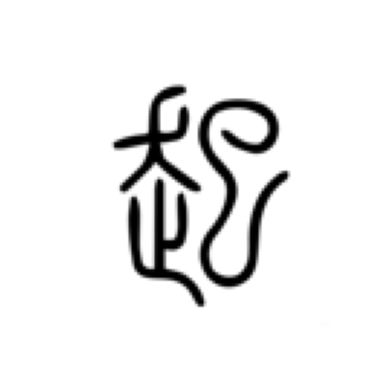

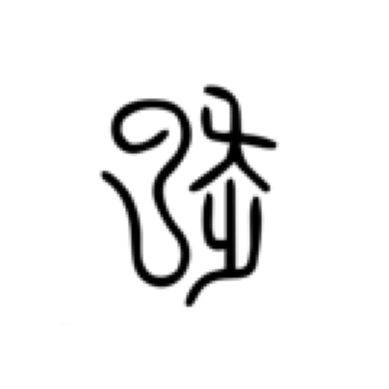

In [6]:
'''TESTING'''

im = Image.open(os.path.join(data_dir, '1') + '/1_1.png').convert("L")
img = np.asarray(im)

plt.imshow(img, cmap='gray')
plt.axis('off')
plt.show()

im_flipped = np.flip(img, axis=1)
plt.imshow(im_flipped, cmap='gray')
plt.axis('off')
plt.show()